In [1]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 


k = 5 # Amount of topics
gamma = 0.2

In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 50 # Amount of documents
V = 18 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 5 

k = 6 # Amount of topics
gamma = 0.2

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from simulator import Simulator

In [5]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1985)  # Live aid
random_initial_data.generate_non_informative(test_data.W)

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: G transformed from K
Success: E transformed from Z
Success: C transformed from Z


<AxesSubplot:>

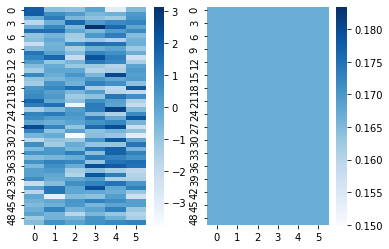

In [8]:
import seaborn as sn
fig, ax = plt.subplots(1,2)
sn.heatmap(test_data.H, cmap='Blues',ax=ax[0])
sn.heatmap(random_initial_data.H, cmap='Blues',ax=ax[1])

<AxesSubplot:>

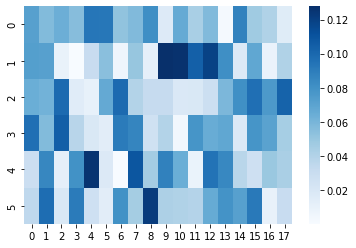

In [9]:
sn.heatmap(test_data.B, cmap='Blues')

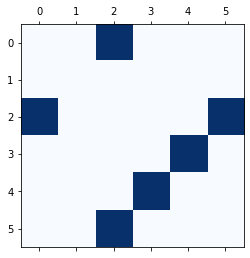

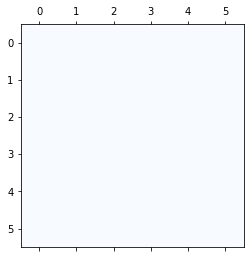

In [10]:
plt.matshow(test_data.G, cmap='Blues')
plt.matshow(random_initial_data.G, cmap='Blues')

In [11]:
test_data.Z[0]

array([[ 0.,  3.,  0.,  0., -1.],
       [ 0.,  0., -1., -1., -1.],
       [ 3.,  0., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0.,  0.,  0., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1.],
       [ 0.,  3.,  0., -1., -1.],
       [ 1.,  0., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 5., -1., -1., -1., -1.]])

In [12]:
random_initial_data.Z[0]

array([[ 5.,  5.,  0.,  0., -1.],
       [ 0.,  4., -1., -1., -1.],
       [ 2.,  2., -1., -1., -1.],
       [ 2., -1., -1., -1., -1.],
       [ 5.,  1.,  3., -1., -1.],
       [ 5.,  0.,  3.,  3.,  1.],
       [-1., -1., -1., -1., -1.],
       [ 0.,  4.,  2., -1., -1.],
       [ 2.,  0., -1., -1., -1.],
       [ 3., -1., -1., -1., -1.],
       [ 3., -1., -1., -1., -1.],
       [ 2., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 2., -1., -1., -1., -1.],
       [ 3.,  1.,  1.,  5.,  1.],
       [ 3., -1., -1., -1., -1.]])

# 2. MC SAMPLER

## 2.1.2 Z,B and H Sampling Tests

In [13]:
from samplers import MC_sample_H
from samplers import MC_sample_B
from samplers import MC_sample_Z
from transformation_functions import update_Theta

In [14]:
Z_copy = random_initial_data.Z.copy()
E_copy = random_initial_data.E.copy()
C_copy = random_initial_data.C.copy()
B_copy = random_initial_data.B.copy()
H_copy = random_initial_data.H.copy()
Theta_copy=random_initial_data.Theta.copy()

alpha = np.ones(V)
step_size = 0.25
W_copy=test_data.W.copy()
Sigma_copy = test_data.Sigma.copy()
K_copy = test_data.K.copy()
G_copy=test_data.G.copy()

Z_sample, E_sample, C_sample = MC_sample_Z(Z_copy, W_copy, Theta_copy, B_copy, E_copy, C_copy, debug=True)
B_sample = MC_sample_B(alpha, C_copy)
H_sample, step_size = MC_sample_H(E_copy, Sigma_copy, K_copy, step_size=step_size,
                                 adaptive_step_ratio=1.5, adaptive_step_threshold=0.55, max_step=0.5)
Theta_sample=update_Theta(Theta_copy,H_sample)


In [15]:
%%time
# Check that the Sampler works properly (This will take... forever)
errors = []
matrix_changes = []
burn_in = 1000
step_size = 0.5
steps = []
heat_H=np.zeros(H_sample.shape)
for i in range(5000):
    H_sample_old=H_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_sample, B_sample, E_sample, C_sample)
    B_sample = MC_sample_B(alpha, C_sample)
    H_sample, step_size = MC_sample_H(E=E_sample, Sigma=Sigma_copy, K=K_copy, H_current=H_sample_old, step_size=step_size,
                                 adaptive_step_ratio=1.1, adaptive_step_threshold=0.99, max_step=0.5)
    Theta_sample=update_Theta(Theta_copy,H_sample)
    matrix_changes.append(~np.all(H_sample_old == H_sample))
    if i >= burn_in:
        errors.append(np.linalg.norm(H_sample - test_data.H))  # Computing error wrt the target matrix
        steps.append(step_size)
        heat_H=heat_H+H_sample

CPU times: user 20min 15s, sys: 17.1 s, total: 20min 32s
Wall time: 21min 2s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64


<AxesSubplot:>

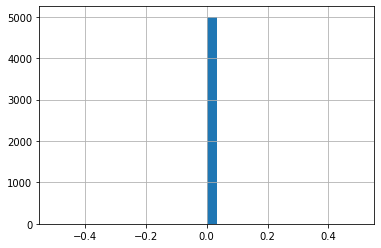

In [16]:
# Matrix should change
matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")

print(matrix_changes.describe())
matrix_changes.hist(bins=30)

H L2-error metrics
count    4000.000000
mean       41.144759
std         0.250589
min        40.662206
25%        40.924603
50%        41.143861
75%        41.365121
max        41.549542
dtype: float64


<AxesSubplot:>

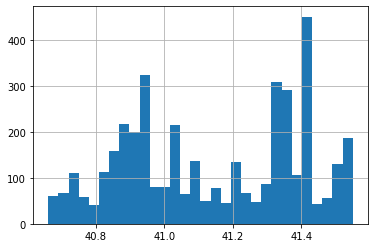

In [17]:
# Error should be distributed close to 0 (I guess...)  # BUG https://trello.com/c/9k2e8PQz/33-mcsampleh-is-not-close-to-expected-target
errors = pd.Series(errors)
print("H L2-error metrics")
print(errors.describe())
errors.hist(bins=30)

H L2-error series


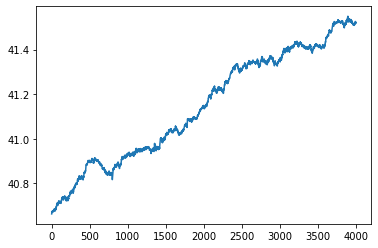

In [18]:
errors.plot()
print("H L2-error series")

Steps
count    4000.000000
mean        0.000008
std         0.000003
min         0.000002
25%         0.000006
50%         0.000008
75%         0.000010
max         0.000023
dtype: float64


<AxesSubplot:>

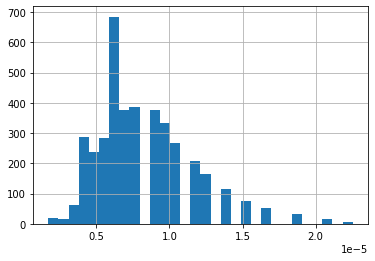

In [19]:
# Matrix should change
steps = pd.Series(steps)
print("Steps")

print(steps.describe())
steps.hist(bins=30)

Steps


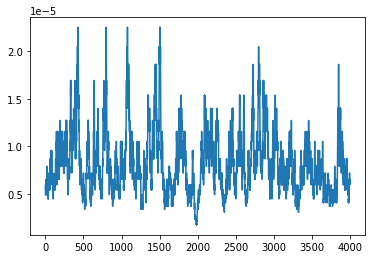

In [20]:
steps.plot()
print("Steps")

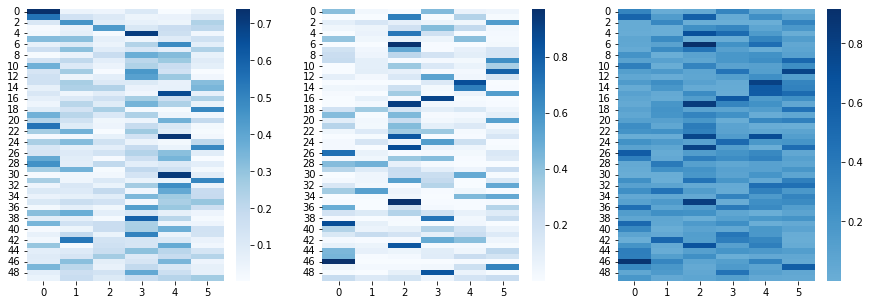

4.625004109682689

In [21]:
import seaborn as sn
from transformation_functions import update_Theta


fig, ax = plt.subplots(1,3, figsize=(15, 5))

last_Theta = update_Theta(np.zeros(H_sample.shape), H_sample)
true_Theta = update_Theta(np.zeros(H_sample.shape), test_data.H)

sn.heatmap(true_Theta, cmap='Blues',ax=ax[0])
sn.heatmap(last_Theta, cmap='Blues',ax=ax[1])
sn.heatmap(abs(true_Theta - last_Theta),cmap='Blues',ax=ax[2],center=0)
plt.show()

np.linalg.norm(true_Theta-last_Theta)

In [22]:
np.random.randint(1,4)

3

<AxesSubplot:>

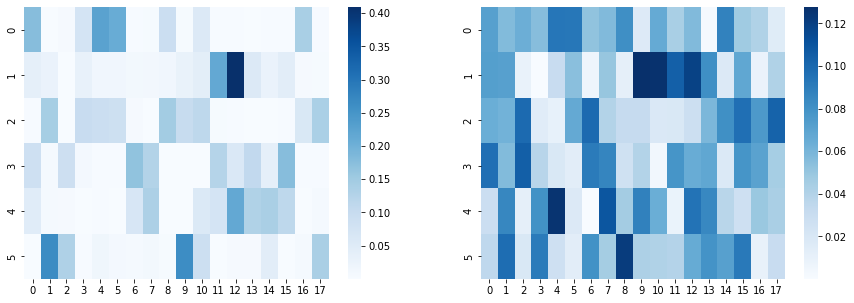

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sn.heatmap(B_sample, cmap='Blues',ax=ax[0])
sn.heatmap(test_data.B, cmap='Blues',ax=ax[1])